In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!ls -a ~/.kaggle

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new
!unzip utkface-new.zip

In [ ]:
!pip install wandb

In [5]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import wandb

In [7]:
!wandb login

wandb: Currently logged in as: benyaminzojaji. Use `wandb login --relogin` to force relogin


In [ ]:
#wandb.init(project='FaceAgeRegression-TransferLearning')

wandb: Currently logged in as: benyaminzojaji. Use `wandb login --relogin` to force relogin


In [8]:
!wandb sweep sweep.yaml

wandb: Creating sweep from: sweep.yaml
wandb: Created sweep with ID: fi20k5mz
wandb: View sweep at: https://wandb.ai/benyaminzojaji/uncategorized/sweeps/fi20k5mz
wandb: Run sweep agent with: wandb agent benyaminzojaji/uncategorized/fi20k5mz


In [10]:
height = width = 112
images = [] # X
ages = [] # Y

for image_name in os.listdir('/content/utkface_aligned_cropped/crop_part1'):
  ages.append(int(image_name.split('_')[0]))

  image = cv2.imread(f'/content/utkface_aligned_cropped/crop_part1/{image_name}')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (width, height))
  images.append(image)

In [11]:
images = pd.Series(images, name='Images')
ages = pd.Series(ages, name='Ages')

dataframe = pd.concat([images, ages], axis=1)
dataframe.head()

,Images,Ages
0,"[[[148, 136, 120], [109, 97, 81], [65, 53, 39]...",24
1,"[[[94, 63, 61], [88, 58, 56], [87, 62, 59], [7...",21
2,"[[[68, 58, 49], [49, 41, 30], [38, 32, 20], [3...",9
3,"[[[10, 9, 7], [12, 11, 9], [13, 12, 10], [13, ...",6
4,"[[[22, 13, 6], [28, 17, 8], [38, 24, 14], [49,...",21


24


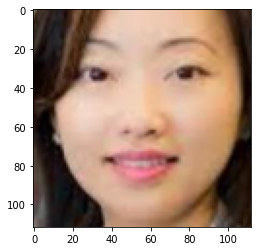

In [12]:
print(dataframe['Ages'][0])
plt.imshow(dataframe['Images'][0])
plt.show()

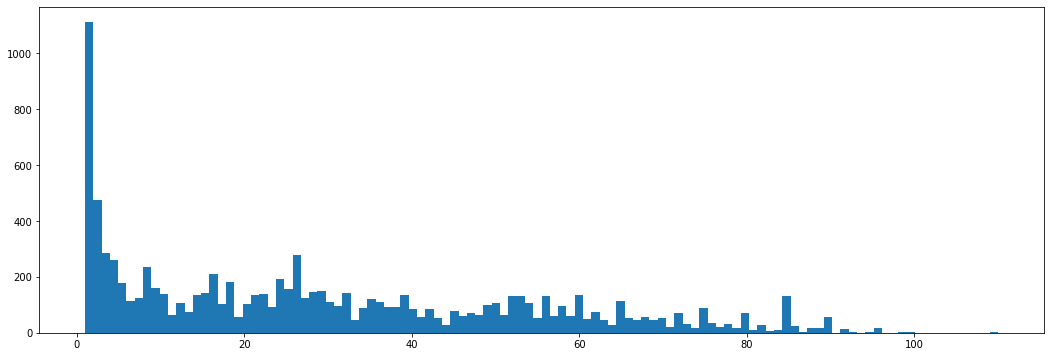

In [13]:
plt.figure(figsize=(18, 6))
plt.hist(dataframe['Ages'], bins=dataframe['Ages'].max())
plt.show()

In [14]:
under_4 = dataframe[dataframe['Ages'] <= 4]
under_4_new = under_4.sample(frac=0.3)

up_4 = dataframe[dataframe['Ages'] > 4]

dataframe = pd.concat([under_4_new, up_4], axis=0)

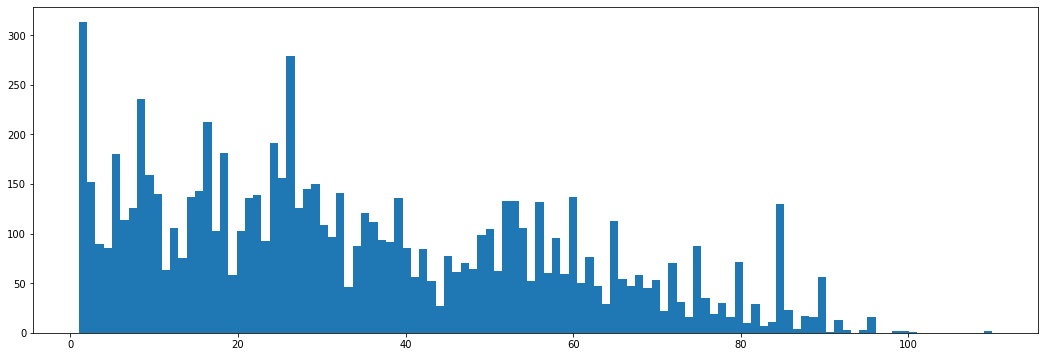

In [15]:
plt.figure(figsize=(18, 6))
plt.hist(dataframe['Ages'], bins=dataframe['Ages'].max())
plt.show()

In [16]:
X = np.array(dataframe['Images'].values.tolist())
Y = np.array(dataframe['Ages'].values.tolist())

In [17]:
print(X.shape)
print(Y.shape)

(8288, 112, 112, 3)
(8288,)


In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

In [19]:
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)

In [20]:
X_train.size()

torch.Size([6630, 112, 112, 3])

In [21]:
X_train = torch.permute(X_train, (0, 3, 2, 1))

In [22]:
X_train.size()

torch.Size([6630, 3, 112, 112])

In [23]:
class Dataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.data = X
        self.target = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y
    
    def __len__(self):
        return len(self.data)

transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

def build_dataset(batch_size):
  dataset = Dataset(X_train, Y_train, transform)
  train_data_loader = DataLoader(dataset, batch_size=batch_size)
  return train_data_loader

In [44]:
loss_function = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def build_optimizer(model, optimizer, learning_rate):
  if optimizer == 'rmsprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
  elif optimizer == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return optimizer

In [38]:
def build_model():
  model = torchvision.models.resnet50(pretrained=True)
  model.fc = nn.Linear(model.fc.in_features, 1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)

  ct = 0
  for child in model.children():
    ct += 1
    if ct < 7:
      for param in child.parameters():
        param.requires_grad = False
  return model

In [39]:
def train():
  with wandb.init():
    config = wandb.config

    train_data = build_dataset(config.batch_size)
    model = build_model()
    optimizer = build_optimizer(model, config.optimizer, config.learning_rate)

    for epoch in range(10):
      total_loss = train_step(model, train_data, optimizer)
      wandb.log({"loss": total_loss, "epochs": epoch})
      print(f"Epoch: {epoch+1}, Loss: {total_loss}")

In [42]:
def train_step(model, train_data, optimizer):
  train_loss = 0
  for images, labels in tqdm(train_data):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()

    preds = model(images)
    loss = loss_function(preds, labels.float())
    loss.backward()
    optimizer.step()

    train_loss += loss
  
  total_loss = train_loss / len(train_data)
  return total_loss

In [45]:
wandb.agent("fi20k5mz", train)

wandb: Agent Starting Run: d4sr21my with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.005023769196354447
wandb: 	optimizer: rmsprop


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/208 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the 

Epoch: 1, Loss: 591.2706298828125


100%|██████████| 208/208 [00:40<00:00,  5.14it/s]


Epoch: 2, Loss: 573.7180786132812


100%|██████████| 208/208 [00:39<00:00,  5.24it/s]


Epoch: 3, Loss: 570.0095825195312


100%|██████████| 208/208 [00:40<00:00,  5.20it/s]


Epoch: 4, Loss: 570.8064575195312


100%|██████████| 208/208 [00:39<00:00,  5.22it/s]


Epoch: 5, Loss: 569.2422485351562


100%|██████████| 208/208 [00:39<00:00,  5.24it/s]


Epoch: 6, Loss: 568.1153564453125


100%|██████████| 208/208 [00:39<00:00,  5.24it/s]


Epoch: 7, Loss: 567.5322265625


100%|██████████| 208/208 [00:39<00:00,  5.25it/s]


Epoch: 8, Loss: 567.2349243164062


100%|██████████| 208/208 [00:39<00:00,  5.25it/s]


Epoch: 9, Loss: 566.4846801757812


100%|██████████| 208/208 [00:39<00:00,  5.26it/s]


Epoch: 10, Loss: 566.2542114257812


epochs,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
epochs,9
loss,566.25421


wandb: Agent Starting Run: y5ehqar1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.003803766058862759
wandb: 	optimizer: adam


100%|██████████| 208/208 [00:41<00:00,  5.00it/s]


Epoch: 1, Loss: 586.4929809570312


100%|██████████| 208/208 [00:40<00:00,  5.10it/s]


Epoch: 2, Loss: 569.3052978515625


100%|██████████| 208/208 [00:41<00:00,  5.07it/s]


Epoch: 3, Loss: 568.5145874023438


100%|██████████| 208/208 [00:41<00:00,  5.07it/s]


Epoch: 4, Loss: 567.7406005859375


100%|██████████| 208/208 [00:40<00:00,  5.08it/s]


Epoch: 5, Loss: 567.2080688476562


100%|██████████| 208/208 [00:40<00:00,  5.07it/s]


Epoch: 6, Loss: 566.8658447265625


100%|██████████| 208/208 [00:41<00:00,  5.07it/s]


Epoch: 7, Loss: 566.8528442382812


100%|██████████| 208/208 [00:40<00:00,  5.08it/s]


Epoch: 8, Loss: 566.3602294921875


100%|██████████| 208/208 [00:40<00:00,  5.09it/s]


Epoch: 9, Loss: 566.0228271484375


100%|██████████| 208/208 [00:40<00:00,  5.08it/s]


Epoch: 10, Loss: 565.744140625


epochs,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
epochs,9
loss,565.74414


wandb: Agent Starting Run: u7n2bzla with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0018628352489763805
wandb: 	optimizer: adam


100%|██████████| 208/208 [00:41<00:00,  5.01it/s]


Epoch: 1, Loss: 593.5100708007812


100%|██████████| 208/208 [00:40<00:00,  5.11it/s]


Epoch: 2, Loss: 565.2145385742188


100%|██████████| 208/208 [00:40<00:00,  5.08it/s]


Epoch: 3, Loss: 565.1978759765625


100%|██████████| 208/208 [00:40<00:00,  5.09it/s]


Epoch: 4, Loss: 565.2885131835938


100%|██████████| 208/208 [00:40<00:00,  5.09it/s]


Epoch: 5, Loss: 565.0216064453125


100%|██████████| 208/208 [00:41<00:00,  4.97it/s]


Epoch: 6, Loss: 564.7669677734375


100%|██████████| 208/208 [00:40<00:00,  5.08it/s]


Epoch: 7, Loss: 564.7994384765625


100%|██████████| 208/208 [00:41<00:00,  5.04it/s]


Epoch: 8, Loss: 564.7048950195312


100%|██████████| 208/208 [00:40<00:00,  5.08it/s]


Epoch: 9, Loss: 564.3184814453125


100%|██████████| 208/208 [00:40<00:00,  5.09it/s]


Epoch: 10, Loss: 564.0026245117188


epochs,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
epochs,9
loss,564.00262


wandb: Agent Starting Run: 3zhkmyz7 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00969110702698677
wandb: 	optimizer: adam


100%|██████████| 208/208 [00:41<00:00,  5.02it/s]


Epoch: 1, Loss: 589.7486572265625


100%|██████████| 208/208 [00:40<00:00,  5.09it/s]


Epoch: 2, Loss: 577.9810791015625


100%|██████████| 208/208 [00:40<00:00,  5.10it/s]


Epoch: 3, Loss: 574.132080078125


100%|██████████| 208/208 [00:40<00:00,  5.10it/s]


Epoch: 4, Loss: 572.3106689453125


100%|██████████| 208/208 [00:40<00:00,  5.11it/s]


Epoch: 5, Loss: 569.39990234375


100%|██████████| 208/208 [00:40<00:00,  5.10it/s]


Epoch: 6, Loss: 569.6260986328125


100%|██████████| 208/208 [00:40<00:00,  5.10it/s]


Epoch: 7, Loss: 569.1537475585938


100%|██████████| 208/208 [00:40<00:00,  5.10it/s]


Epoch: 8, Loss: 569.2489013671875


100%|██████████| 208/208 [00:40<00:00,  5.12it/s]


Epoch: 9, Loss: 568.3046875


100%|██████████| 208/208 [00:40<00:00,  5.11it/s]


Epoch: 10, Loss: 566.53466796875


epochs,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▂▂▁
epochs,9
loss,566.53467


wandb: Agent Starting Run: 3d3bk855 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0055280438327563845
wandb: 	optimizer: rmsprop


100%|██████████| 208/208 [00:40<00:00,  5.12it/s]


Epoch: 1, Loss: 595.6815795898438


100%|██████████| 208/208 [00:40<00:00,  5.19it/s]


Epoch: 2, Loss: 573.703857421875


100%|██████████| 208/208 [00:40<00:00,  5.20it/s]


Epoch: 3, Loss: 570.9224243164062


100%|██████████| 208/208 [00:40<00:00,  5.19it/s]


Epoch: 4, Loss: 570.1107788085938


100%|██████████| 208/208 [00:39<00:00,  5.22it/s]


Epoch: 5, Loss: 570.9856567382812


100%|██████████| 208/208 [00:39<00:00,  5.21it/s]


Epoch: 6, Loss: 569.1585083007812


100%|██████████| 208/208 [00:39<00:00,  5.24it/s]


Epoch: 7, Loss: 568.5826416015625


100%|██████████| 208/208 [00:39<00:00,  5.25it/s]


Epoch: 8, Loss: 568.193115234375


100%|██████████| 208/208 [00:39<00:00,  5.25it/s]


Epoch: 9, Loss: 567.26904296875


100%|██████████| 208/208 [00:39<00:00,  5.27it/s]


Epoch: 10, Loss: 567.1107177734375


epochs,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
epochs,9
loss,567.11072


wandb: Agent Starting Run: d6j2n755 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001933925066325826
wandb: 	optimizer: rmsprop


100%|██████████| 208/208 [00:40<00:00,  5.08it/s]


Epoch: 1, Loss: 583.2554321289062


100%|██████████| 208/208 [00:40<00:00,  5.15it/s]


Epoch: 2, Loss: 567.7120971679688


100%|██████████| 208/208 [00:40<00:00,  5.15it/s]


Epoch: 3, Loss: 567.2455444335938


100%|██████████| 208/208 [00:40<00:00,  5.14it/s]


Epoch: 4, Loss: 566.6724853515625


100%|██████████| 208/208 [00:40<00:00,  5.16it/s]


Epoch: 5, Loss: 566.1563720703125


100%|██████████| 208/208 [00:40<00:00,  5.17it/s]


Epoch: 6, Loss: 565.9276733398438


100%|██████████| 208/208 [00:40<00:00,  5.17it/s]


Epoch: 7, Loss: 565.533447265625


100%|██████████| 208/208 [00:40<00:00,  5.17it/s]


Epoch: 8, Loss: 565.2864990234375


100%|██████████| 208/208 [00:40<00:00,  5.19it/s]


Epoch: 9, Loss: 564.8056640625


100%|██████████| 208/208 [00:40<00:00,  5.19it/s]


Epoch: 10, Loss: 564.1383056640625


epochs,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▂▂▂▁▁▁
epochs,9
loss,564.13831


wandb: Agent Starting Run: xhtbqk1x with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.006928460067552702
wandb: 	optimizer: rmsprop


100%|██████████| 208/208 [00:40<00:00,  5.16it/s]


Epoch: 1, Loss: 594.9179077148438


100%|██████████| 208/208 [00:39<00:00,  5.22it/s]


Epoch: 2, Loss: 572.988525390625


100%|██████████| 208/208 [00:39<00:00,  5.23it/s]


Epoch: 3, Loss: 571.7796630859375


100%|██████████| 208/208 [00:39<00:00,  5.23it/s]


Epoch: 4, Loss: 570.3587036132812


100%|██████████| 208/208 [00:39<00:00,  5.26it/s]


Epoch: 5, Loss: 569.2333374023438


100%|██████████| 208/208 [00:39<00:00,  5.27it/s]


Epoch: 6, Loss: 568.0535888671875


100%|██████████| 208/208 [00:39<00:00,  5.27it/s]


Epoch: 7, Loss: 567.3071899414062


100%|██████████| 208/208 [00:39<00:00,  5.28it/s]


Epoch: 8, Loss: 566.680908203125


100%|██████████| 208/208 [00:39<00:00,  5.29it/s]


Epoch: 9, Loss: 565.3065795898438


100%|██████████| 208/208 [00:39<00:00,  5.29it/s]


Epoch: 10, Loss: 565.2189331054688


epochs,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▁▁▁▁
epochs,9
loss,565.21893


wandb: Agent Starting Run: iah7sjf5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00886781235228782
wandb: 	optimizer: rmsprop


100%|██████████| 208/208 [00:40<00:00,  5.15it/s]


Epoch: 1, Loss: 606.1195068359375


100%|██████████| 208/208 [00:39<00:00,  5.21it/s]


Epoch: 2, Loss: 576.2090454101562


100%|██████████| 208/208 [00:39<00:00,  5.22it/s]


Epoch: 3, Loss: 572.5574340820312


100%|██████████| 208/208 [00:39<00:00,  5.21it/s]


Epoch: 4, Loss: 570.9010009765625


100%|██████████| 208/208 [00:39<00:00,  5.24it/s]


Epoch: 5, Loss: 569.6096801757812


100%|██████████| 208/208 [00:39<00:00,  5.23it/s]


Epoch: 6, Loss: 570.8114013671875


100%|██████████| 208/208 [00:39<00:00,  5.25it/s]


Epoch: 7, Loss: 570.0711059570312


100%|██████████| 208/208 [00:39<00:00,  5.26it/s]


Epoch: 8, Loss: 568.6377563476562


100%|██████████| 208/208 [00:39<00:00,  5.26it/s]


Epoch: 9, Loss: 567.8214111328125


100%|██████████| 208/208 [00:39<00:00,  5.26it/s]


Epoch: 10, Loss: 567.4967651367188


epochs,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▂▁▁▁▁
epochs,9
loss,567.49677


wandb: Agent Starting Run: eo9o8d58 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0006324301586484499
wandb: 	optimizer: rmsprop


100%|██████████| 208/208 [00:40<00:00,  5.08it/s]


Epoch: 1, Loss: 582.1035766601562


100%|██████████| 208/208 [00:40<00:00,  5.15it/s]


Epoch: 2, Loss: 564.41650390625


100%|██████████| 208/208 [00:40<00:00,  5.15it/s]


Epoch: 3, Loss: 565.503173828125


100%|██████████| 208/208 [00:40<00:00,  5.13it/s]


Epoch: 4, Loss: 564.3203735351562


100%|██████████| 208/208 [00:40<00:00,  5.14it/s]


Epoch: 5, Loss: 564.1222534179688


100%|██████████| 208/208 [00:40<00:00,  5.14it/s]


Epoch: 6, Loss: 564.0574951171875


100%|██████████| 208/208 [00:40<00:00,  5.14it/s]


Epoch: 7, Loss: 563.6842041015625


100%|██████████| 208/208 [00:40<00:00,  5.15it/s]


Epoch: 8, Loss: 563.320556640625


100%|██████████| 208/208 [00:40<00:00,  5.15it/s]


Epoch: 9, Loss: 562.7594604492188


100%|██████████| 208/208 [00:40<00:00,  5.15it/s]


Epoch: 10, Loss: 561.9181518554688


epochs,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▂▂▂▁▁▁
epochs,9
loss,561.91815


wandb: Agent Starting Run: 6m4airx7 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.005005197795529241
wandb: 	optimizer: rmsprop


100%|██████████| 208/208 [00:40<00:00,  5.14it/s]


Epoch: 1, Loss: 590.30908203125


100%|██████████| 208/208 [00:39<00:00,  5.20it/s]


Epoch: 2, Loss: 573.1849975585938


100%|██████████| 208/208 [00:39<00:00,  5.22it/s]


Epoch: 3, Loss: 570.2564086914062


100%|██████████| 208/208 [00:39<00:00,  5.21it/s]


Epoch: 4, Loss: 569.4971313476562


100%|██████████| 208/208 [00:39<00:00,  5.24it/s]


Epoch: 5, Loss: 569.3130493164062


100%|██████████| 208/208 [00:39<00:00,  5.22it/s]


Epoch: 6, Loss: 568.8610229492188


100%|██████████| 208/208 [00:39<00:00,  5.24it/s]


Epoch: 7, Loss: 568.8432006835938


100%|██████████| 208/208 [00:39<00:00,  5.25it/s]


Epoch: 8, Loss: 567.8623046875


100%|██████████| 208/208 [00:39<00:00,  5.24it/s]


Epoch: 9, Loss: 567.6075439453125


100%|██████████| 208/208 [00:39<00:00,  5.25it/s]


Epoch: 10, Loss: 567.2039184570312


epochs,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
epochs,9
loss,567.20392


wandb: Agent Starting Run: yhicm2wb with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00837897973644999
wandb: 	optimizer: rmsprop


100%|██████████| 208/208 [00:40<00:00,  5.16it/s]


Epoch: 1, Loss: 594.880126953125


100%|██████████| 208/208 [00:39<00:00,  5.21it/s]


Epoch: 2, Loss: 573.9765014648438


100%|██████████| 208/208 [00:39<00:00,  5.22it/s]


Epoch: 3, Loss: 571.1245727539062


100%|██████████| 208/208 [00:40<00:00,  5.17it/s]


Epoch: 4, Loss: 570.6747436523438


100%|██████████| 208/208 [00:39<00:00,  5.23it/s]


Epoch: 5, Loss: 568.9223022460938


100%|██████████| 208/208 [00:39<00:00,  5.23it/s]


Epoch: 6, Loss: 566.7322387695312


100%|██████████| 208/208 [00:39<00:00,  5.23it/s]


Epoch: 7, Loss: 566.5720825195312


100%|██████████| 208/208 [00:39<00:00,  5.24it/s]


Epoch: 8, Loss: 564.3152465820312


100%|██████████| 208/208 [00:39<00:00,  5.24it/s]


Epoch: 9, Loss: 564.34619140625


100%|██████████| 208/208 [00:39<00:00,  5.25it/s]


Epoch: 10, Loss: 561.6090087890625


epochs,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▃▂▂▂▂▁
epochs,9
loss,561.60901


wandb: Agent Starting Run: 9bwbywu8 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.003727133942285679
wandb: 	optimizer: adam


100%|██████████| 208/208 [00:41<00:00,  5.02it/s]


Epoch: 1, Loss: 586.9107666015625


100%|██████████| 208/208 [00:40<00:00,  5.10it/s]


Epoch: 2, Loss: 569.21875


 11%|█         | 22/208 [00:04<00:39,  4.75it/s]

In [ ]:
# save
torch.save(model.state_dict(), 'FaceAgeRegression.pth')

In [ ]:
# empty cache, in case you got CUDA space error.
torch.cuda.empty_cache()

import gc
gc.collect()